# Counter Strike Coaching Strategies - Analysis

### Import class and libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import numpy as np
from process_game_state import ProcessGameState


### Create game state instance

In [2]:
game_state = ProcessGameState('data/game_state_frame_data.parquet')
game_state.data.head()


,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
0,1,2511,T,Team1,100,100,True,-1310,-3333,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
1,1,2527,T,Team1,100,100,True,-1303,-3322,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
2,1,2543,T,Team1,100,100,True,-1290,-3303,292,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
3,1,2559,T,Team1,100,100,True,-1275,-3280,290,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
4,1,2575,T,Team1,100,100,True,-1254,-3262,288,...,900,TSpawn,1,01:55,5,5,False,de_overpass,0.0,Player0


### Create Team 2 data frames

In [3]:
# Filter the data for Team2
team2_data = game_state.data[game_state.data['team'] == "Team2"]

# Separate the data into T and CT sides
team2_T_data = team2_data[team2_data['side'] == "T"]
team2_CT_data = team2_data[team2_data['side'] == "CT"]


## Question 1: Is entering via the light blue boundary a common strategy used by Team 2 on T side?

In [4]:
# Define the boundaries for the light blue boundary
xy_bounds = [(-1735, 250), (-2024, 398), (-2806, 742),
             (-2472, 1233), (-1565, 580)]
closed_boundary_coords = np.concatenate((xy_bounds, [xy_bounds[0]]))
z_bounds = (285, 421)

# Get the min and max of the x and y coordinates for visualization
x_coords = [coord[0] for coord in xy_bounds]
y_coords = [coord[1] for coord in xy_bounds]

x_min = min(x_coords)
x_max = max(x_coords)
y_min = min(y_coords)
y_max = max(y_coords)


### Calculate the number of times Team 2 enters via the light blue boundary using a basic boundary detection algorithm

In [9]:
# Get the number of times the player is in bounds for each round
team2_T_in_bounds = game_state.check_boundaries(
    xy_bounds, z_bounds, team2_T_data)
print(team2_T_in_bounds)

# Get the number of rounds the boundary is entered
team2_T_entered = [True if num > 0 else False for num in team2_T_in_bounds]
team2_T_entered_count = {True: 0, False: 0}
for round in team2_T_entered:
    team2_T_entered_count[round] += 1

print("The number of rounds that Team 2 enters the boundary on T side is " +
      str(team2_T_entered_count[True]) + " out of " + str(len(team2_T_in_bounds)) + " rounds.")


[0, 19, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
The number of rounds that Team 2 enters the boundary on T side is 2 out of 15 rounds.


### Calculate the number of times Team 2 enters via the light blue boundary using a more advanced boundary detection algorithm (Matplotlib Path class)

In [10]:
# Get the number of times the player is in bounds for each round
team2_T_in_bounds = game_state.check_boundaries_with_matplotlib(
    closed_boundary_coords, z_bounds, team2_T_data)
print(team2_T_in_bounds)

# Get the number of rounds the boundary is entered
team2_T_entered = [True if num > 0 else False for num in team2_T_in_bounds]
team2_T_entered_count = {True: 0, False: 0}
for round in team2_T_entered:
    team2_T_entered_count[round] += 1

print("The number of rounds that Team 2 enters the boundary on T side is " +
      str(team2_T_entered_count[True]) + " out of " + str(len(team2_T_in_bounds)) + " rounds.")


[0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
The number of rounds that Team 2 enters the boundary on T side is 1 out of 15 rounds.


### Visualize the boundary detection algorithms

#### Basic boundary detection algorithm

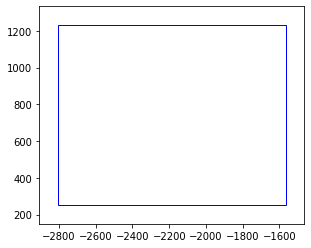

In [7]:
fig, ax = plt.subplots()
rect = mpatches.Rectangle((x_min, y_min), x_max - x_min,
                          y_max - y_min, fill=False, edgecolor='blue')
ax.add_patch(rect)
ax.set_xlim(x_min - 100, x_max + 100)  # Set the x-axis limits
ax.set_ylim(y_min - 100, y_max + 100)  # Set the y-axis limits
plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to equal
plt.show()


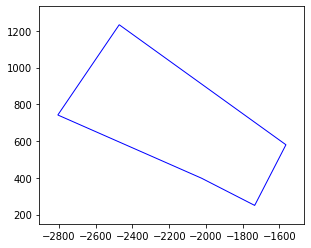

In [8]:
boundary_path = mpath.Path(closed_boundary_coords)

fig, ax = plt.subplots()
patch = mpatches.PathPatch(boundary_path, facecolor='none', edgecolor='blue')
ax.add_patch(patch)
ax.set_xlim(x_min - 100, x_max + 100)  # Set the x-axis limits
ax.set_ylim(y_min - 100, y_max + 100)  # Set the y-axis limits
plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to equal
plt.show()


## Question 2: What is the average timer that Team 2 on T side enters Bombsite B with at least 2 rifles or SMGs?

## Question 3: Where should we suspect Team 2 on CT side to be waiting inside Bombsite B?